Data Preparation
================

We use the UrbanSound8K dataset. It can be downloaded from the [official website](https://urbansounddataset.weebly.com/download-urbansound8k.html). The archive contains a folder *UrbanSound8K* that goes into the root directory of this project.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from audio_helper import wav_info

In [2]:
metadata_df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")

test_metadata_df = metadata_df[metadata_df['fold'] == 10]
val_metadata_df = metadata_df[metadata_df['fold'] == 9]
train_metadata_df = metadata_df[~metadata_df.fold.isin([9,10])]

Lets have a look at the data first before we start preparing it.

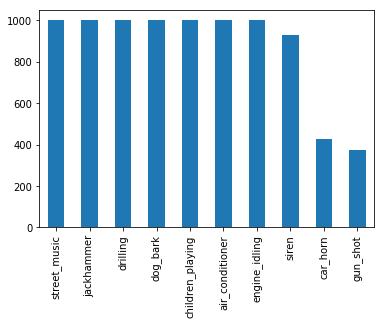

In [3]:
metadata_df['class'].value_counts().plot(kind='bar');

There are 10 categories with similar amount of testdata with the exception of *car_horn* and *gun_shot*.

Now we will have a quick look at the audio files in the dataset. We use librosa the parse and process the .wav files.

In [4]:
def get_wav_file_path(fold, filename):
    return "UrbanSound8K/audio/fold{}/{}".format(fold, filename)

def get_duration_sample_freq(metadata_row):
    filepath = get_wav_file_path(metadata_row['fold'], metadata_row['slice_file_name'])
    
    headers = wav_info(filepath)
    duration = librosa.get_duration(filename=filepath)
    
    return (duration, headers['BitsPerSample'], headers['ByteRate'], headers['NumChannels'])

# This takes a while (15min)
#dur_sr = metadata_df.apply(get_duration_sample_freq, axis=1);
#metadata_df = pd.DataFrame(dur_sr.to_list(), index=metadata_df.index, columns=['duration', 'bit_depth', 'byte_rate', 'num_channels'])
#metadata_df.to_pickle('metadata_cached')

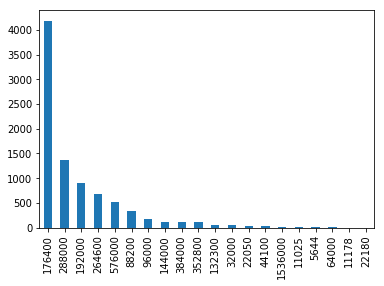

In [5]:
metadata_df = pd.read_pickle('metadata_cached')

sr_stats = metadata_df['byte_rate'].value_counts()
sr_stats.plot(kind='bar');

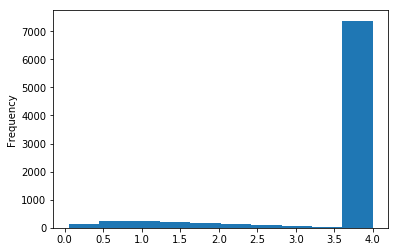

In [6]:
metadata_df['duration'].plot.hist();

In [7]:
metadata_per_phase = {
    'train': train_metadata_df,
    'val': val_metadata_df,
    'test': test_metadata_df
}

spec_folder = "UrbanSound8K/spectogram/"
if not os.path.exists(spec_folder):
    os.makedirs(spec_folder)

bitmap_folder = "UrbanSound8K/bitmap/"
if not os.path.exists(bitmap_folder):
    os.makedirs(bitmap_folder)

def generate_spectogram(y, sr, save_class_folder):
    # trying to get as close as possible to 224x224
    fig = plt.figure(figsize=[0.72,0.72])

    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    Spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(Spec, ref=np.max))

    save_file = save_class_folder + str(row['slice_file_name']) + '.png'
    plt.savefig(save_file, format='png',dpi=400, bbox_inches='tight',pad_inches=0)

    fig.clf()
    plt.close(fig)
    plt.close('all')

    del fig,ax,Spec

def generate_bitmap(y, sr, save_class_folder):
    dur = librosa.get_duration(y=y, sr=sr)
    y_int = (((y+1)*np.iinfo(np.uint16).max)/2).astype(np.uint16)    
    mask = np.ones(y_int.shape[0], dtype=np.uint16)
    
    bitmaps_out = []
    for k in range(0,16):
        y_bits = np.bitwise_and(mask, y_int, dtype=np.uint16)
        y_bits = (y_bits > 0)
        bitmaps_out.append(np.packbits(y_bits))
        mask = np.left_shift(mask, 1)

    out = np.array(bitmaps_out)

    save_file = save_class_folder + '/' + str(row['slice_file_name'])
    np.savez_compressed(save_file, out)
    
    del y_int,mask,out


for phase in ['train','val','test']:
    metadata = metadata_per_phase[phase]
    
    i = 1
    
    spec_save_folder = spec_folder + phase + '/'
    bitmap_save_folder = bitmap_folder + phase + '/'
    
    for idx, row in metadata.iterrows():
        filepath = get_wav_file_path(row['fold'], row['slice_file_name'])

        spec_class_folder = spec_save_folder + row['class'] + '/'
        bitmap_class_folder = bitmap_save_folder + row['class'] + '/'

        if not os.path.exists(spec_class_folder):
            os.makedirs(spec_class_folder)
        if not os.path.exists(bitmap_class_folder):
            os.makedirs(bitmap_class_folder)
        
        # Sample rate of 44100 Hz, same as on a Audio CD
        y, sr = librosa.load(filepath, sr=44100)
        
        generate_spectogram(y, sr, spec_class_folder)
        generate_bitmap(y, sr, bitmap_class_folder)
            
        if i % 500 == 0:
            print("Processed {} wav files".format(i))
        
        i += 1
        
        del filepath, y, sr

Processed 500 wav files
Processed 1000 wav files
Processed 1500 wav files
Processed 2000 wav files
Processed 2500 wav files
Processed 3000 wav files
Processed 3500 wav files
Processed 4000 wav files
Processed 4500 wav files
Processed 5000 wav files
Processed 5500 wav files
Processed 6000 wav files
Processed 6500 wav files
Processed 7000 wav files
Processed 500 wav files
Processed 500 wav files


In [18]:
name = test_metadata_df['slice_file_name' 'fold'][9]
name

SyntaxError: invalid syntax (<ipython-input-18-5d2fceb22f28>, line 1)